In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

from dask.distributed import Client


import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
#cc.start_cluster()
client = Client('tcp://10.0.64.12:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.12:8786 Dashboard: http://10.0.64.12:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [4]:
def find_temp(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                          chunks={'st_ocean': None}, n=n_files,
                          time_units = time_units, offset=offset, use_cache=False)
    upper_temp_eq = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=slice(-217,-95)).sel(time=slice(pd.datetime(1998,1,1),None))\
                        .mean('time').load() - 273.15
    upper_temp_140w = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=slice(-8,10))\
                        .sel(xt_ocean=-140.,method='nearest').sel(time=slice(pd.datetime(1998,1,1),None))\
                        .mean('time').load() - 273.15

    return upper_temp_eq, upper_temp_140w


def find_u(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    u = cc.get_nc_variable(expt, 'ocean.nc', 'u',
                          chunks={'st_ocean': None}, n=n_files,
                          time_units = time_units, offset=offset, use_cache=False)
    upper_u_eq = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=slice(-217,-95)).sel(time=slice(pd.datetime(1998,1,1),None))\
                        .mean('time').load()*100
    upper_u_140w = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=slice(-8,10))\
                        .sel(xu_ocean=-140.,method='nearest').sel(time=slice(pd.datetime(1998,1,1),None))\
                        .mean('time').load()*100

    return upper_u_eq, upper_u_140w


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


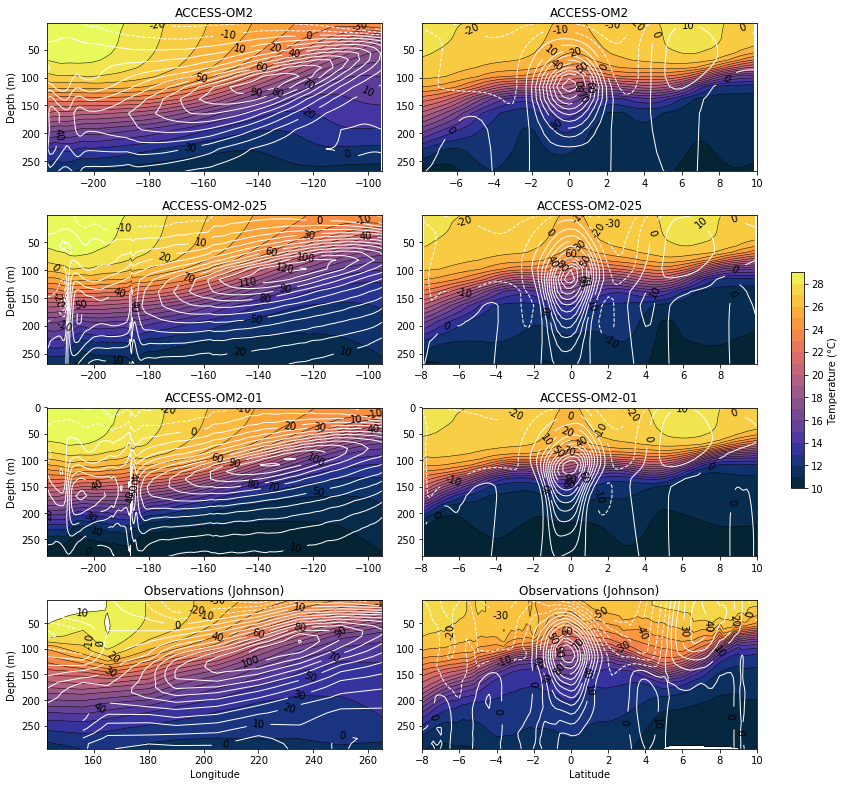

In [5]:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

fig = plt.figure(figsize=(12,12))
for i, ekey in enumerate(exptdata.exptdict.keys()):
    upper_temp_eq, upper_temp_140w = find_temp(ekey)
    upper_u_eq, upper_u_140w = find_u(ekey)

    plt.subplot(4,2,2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   levels=clevelsT,
                                   add_colorbar=False)
    upper_temp_eq.plot.contour(colors='k', levels=clevelsT,
                                   add_colorbar=False,linewidths=0.5)
#    p2=upper_u_eq.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_eq.xu_ocean,upper_u_eq.st_ocean)
    p2=plt.contour(xv,yv,upper_u_eq,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(exptdata.exptdict[ekey]['desc'])


    plt.subplot(4,2,2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     levels=clevelsT,
                                     add_colorbar=False)
    upper_temp_140w.plot.contour(colors='k', levels=clevelsT,
                                     add_colorbar=False,linewidths=0.5)
#    p4=upper_u_140w.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_140w.yu_ocean,upper_u_140w.st_ocean)
    p4=plt.contour(xv,yv,upper_u_140w,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(exptdata.exptdict[ekey]['desc'])


obs_file = xr.open_dataset('/g/data1/v45/fw4078/obs-data/meanfit_m.cdf')
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(XLON=220, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

obs_u = obs_file['UM']
obs_u_140w = obs_u.sel(ZDEP1_50=slice(0,300)).sel(XLON=220., method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
obs_u_eq = obs_u.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
lon_u_obs = obs_u_eq.XLON

plt.subplot(4,2,7)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT)
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('Observations (Johnson)')


plt.subplot(4,2,8)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT)
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('Observations (Johnson)')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Temperature (°C)')

fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
savefigure('equatorial_pacific')